In [1]:
#importing pacakages

import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
#hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval =10
random_seed = 1

torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
#data loader

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.data/',train=True,download=True,
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,),(0.3081,))])),
    batch_size = batch_size_train,shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.data/',train = False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,),(0.3081,))
    ])),
    batch_size = batch_size_test, shuffle = True
)

In [4]:
examples = enumerate(test_loader)
batch_idx,(example_data, example_targets) = next(examples)

example_data.shape
batch_idx


0

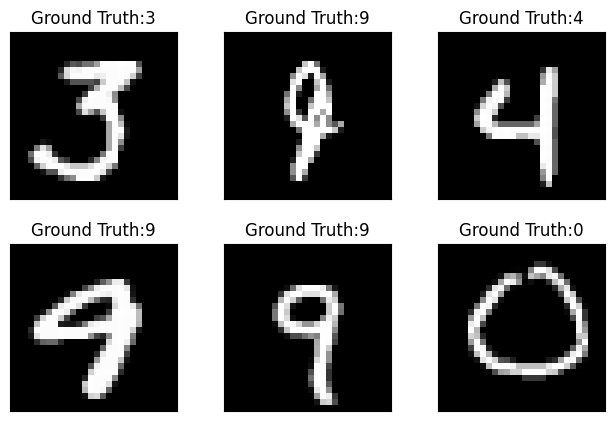

In [5]:
fig1 = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation= 'none')
    plt.title('Ground Truth:{}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

#fig2 = plt.figure()
#plt.plot(example_data[i][0])


In [6]:
#building the network
# will use 2D convolutional layers followed by two fully connected or linear layers
#relu activation function
#two dropout layers regularization

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d( in_channels = 1,out_channels = 10,kernel_size= 5)
        self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features = 320, out_features = 50)
        self.fc2 = nn.Linear(in_features= 50,out_features= 10)

    def forward(self, X):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training= self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
#alternative class
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        input_dimension = 28
        kernel_size = 5
        last_conv_out = ((input_dimension-kernel_size+1)/2 - kernel_size + 1)/2

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  #nn.cov2d has relu activation function as default
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5),
            #nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features= int(pow(last_conv_out,2)*20), out_features= 50, bias= True),
            nn.Linear(in_features= 50, out_features= 10, bias= True)

        )

    def forward(self, x):
        x = self.net(x)
        return F.log_softmax(x, dim=1)
        
network = CNNet()
optimizer = optim.SGD(network.parameters(), lr= learning_rate, momentum= momentum)

In [9]:
training_losses = []
training_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]


In [10]:
def train (epoch):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            #print('Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(
            #epoch, batch_idx*len(data),len(train_loader.dataset),
            #100.* batch_idx*len(data)/len(train_loader.dataset),loss.item()
            #))
            training_losses.append(loss.item())
            training_counter.append(
            (batch_idx*batch_size_train + ((epoch-1)*len(train_loader.dataset)))
        )
        
            #torch.save(network.state_dict(),'model.pth')
            #torch.save(optimizer.state_dict(),'optimizer.pth')

In [11]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data,target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output,target,size_average= False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            #correct += (pred == target).sum()
        
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

    print('\n Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss,correct,len(test_loader.dataset),100.* correct/len(test_loader.dataset)
        ))
    print(test_losses)

In [12]:

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()




/home/codespace/.python/current/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 Test set: Average loss: 2.3164, Accuracy: 959/10000 (10%)

[2.316372119140625]

 Test set: Average loss: 0.1349, Accuracy: 9608/10000 (96%)

[2.316372119140625, 0.13492401733398438]

 Test set: Average loss: 0.0845, Accuracy: 9743/10000 (97%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594]

 Test set: Average loss: 0.0739, Accuracy: 9784/10000 (98%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754]


Text(0, 0.5, 'negative log likelihood loss')

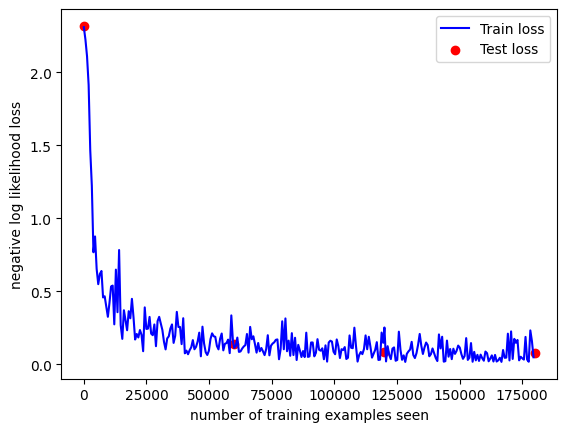

In [13]:
#training curve
fig = plt.figure()
plt.plot(training_counter, training_losses,color = 'blue')
plt.scatter(test_counter, test_losses,color = 'red')
plt.legend(['Train loss','Test loss'],loc = 'upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [14]:
with torch.no_grad():
    output1 = network(example_data)



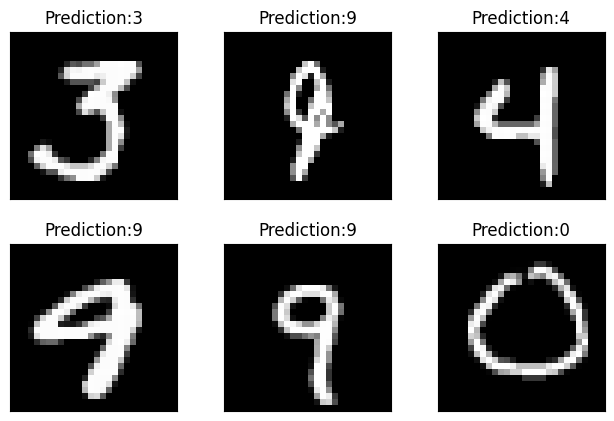

In [15]:
fig2 = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Prediction:{}".format(
        output1.data.max(1,keepdim = True)[1][i].item()
    ))

    plt.xticks([])
    plt.yticks([])

In [16]:
#continuing from checkpoint

continued_network = CNNet()
continued_optimizer = optim.SGD(continued_network.parameters(),lr = learning_rate, momentum=momentum)

network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)


In [17]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()


 Test set: Average loss: 0.0642, Accuracy: 9792/10000 (98%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754, 0.06417101974487305]

 Test set: Average loss: 0.0664, Accuracy: 9796/10000 (98%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754, 0.06417101974487305, 0.06642756423950195]

 Test set: Average loss: 0.0539, Accuracy: 9827/10000 (98%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754, 0.06417101974487305, 0.06642756423950195, 0.05389942016601563]

 Test set: Average loss: 0.0491, Accuracy: 9843/10000 (98%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754, 0.06417101974487305, 0.06642756423950195, 0.05389942016601563, 0.04905379371643066]

 Test set: Average loss: 0.0489, Accuracy: 9854/10000 (99%)

[2.316372119140625, 0.13492401733398438, 0.08453167419433594, 0.07391172218322754, 0.06417101974487305, 0.06642756423950195, 0.05389942016601563, 0.

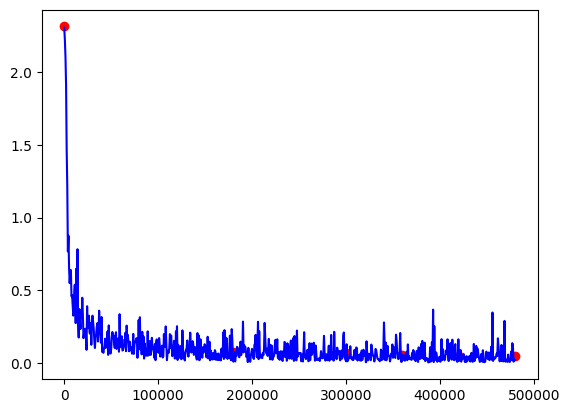

In [18]:
fig3 = plt.figure()

plt.scatter(test_counter,test_losses,color = 'red')
plt.plot(training_counter,training_losses,color = 'blue')



In [19]:
def plotImages(n, data,targets, pred = None):
    fig = plt.figure()
    ncols = 3
    nrows = n//ncols

    for i in range(n):
        plt.subplot(nrows,ncols,i+1)
        plt.tight_layout()
        plt.imshow(data[i][0],cmap='gray',interpolation='none')
        if pred != None:
            plt.title("Ground truth:{}| Pred: {}".format(targets[i],pred[i]))
        else:
            plt.title("Ground Truth: {}".format(targets[i]))
        plt.xticks([])
        plt.yticks([])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

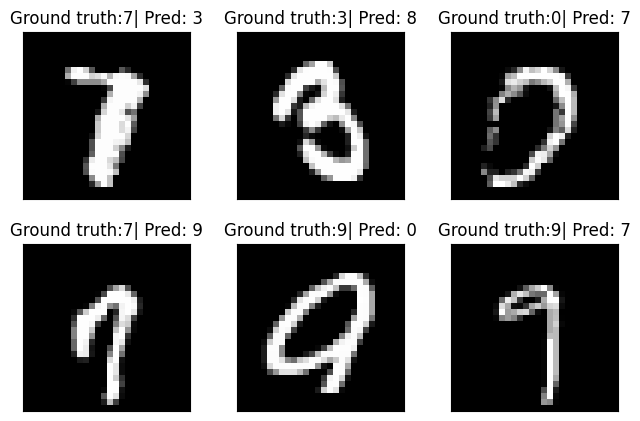

In [20]:

continued_network.eval()
pred = continued_network(example_data).max(1).indices
idxs = pred != example_targets

plotImages(6, example_data[idxs],example_targets[idxs],pred[idxs])

idxs




In [21]:
example_targets

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

Bad pipe message: %s [b"\xd7\xa9\x02\xd5\x12\t\xda\x90e\xf4\t\xccl\x88*T\x1ej \x8f_\xd1X\t\xe6Q\x94\xbe\xc3\x9a\xfa'=\xecW%\xc9\xad@g\xdf\xa1\xf3f\x8b;\xd9T\x87\xc0\x92\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00"]
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xcd\xea\xac\xa3\x0b\xc2/2\xe3\xf5Q\x1fT\xe7#\xe4h[\xad\x8e\xff\x9c']
Bad pipe message: %s [b"\xd4\x8dC\xc9\x07d\x02E\xa0\x8c\x9d\x04J\x83E\xe2: \x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g